# Task 1: Sentence Classification

In [1]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers.keras_callbacks import KerasMetricCallback
import torch
from datasets import Dataset
from pprint import pprint

import os
wandb_api_key = "1a489be8947a5bbf94fcc41855e40beaab35312e" # replace with your own wandb_api_key
os.environ['WANDB_API_KEY'] = wandb_api_key

# Imports to produce metrics and graphs for assessing model
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

# implement early stopping since very few datapoints and plateauing performance
from transformers import EarlyStoppingCallback

# to update trainingargs for final model
from dataclasses import replace

g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Seed everything - AI generated cell
import random
import numpy as np
import torch
import os
from transformers import set_seed

def set_seed(seed=42):
    """Set all random seeds for complete reproducibility"""
    random.seed(seed)          # Python's built-in random module
    np.random.seed(seed)      # NumPy's random number generator
    torch.manual_seed(seed)    # PyTorch's CPU random seed
    torch.cuda.manual_seed(seed)       # PyTorch's GPU random seed
    torch.cuda.manual_seed_all(seed)   # If using multi-GPU
    os.environ['PYTHONHASHSEED'] = str(seed)  # Python hash seed
    torch.backends.cudnn.deterministic = True  # CuDNN deterministic mode
    torch.backends.cudnn.benchmark = False     # Disable CuDNN autotuner

# ---- 1. Hardware Enforcement ----
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Disable GPU
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # For CPU determinism
torch.use_deterministic_algorithms(True)  # Force deterministic ops

# ---- 2. Seed Everything ----
set_seed(42)  # Call this immediately after imports

# ---- 3. CPU-Specific Config ----
torch.set_num_threads(1)  # Single-threaded execution

import transformers
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch: 2.7.1+cpu
Transformers: 4.52.4
CUDA available: False


In [4]:
# 2. Load Classification Dataset
# from google.colab import drive
# drive.mount('/content/drive')

# Replace with location of your own: classification_data.csv
# file_path_drive = '/content/drive/MyDrive/BrainStation/ML Dream/takehome/security/classification_data.csv'

file_path_drive = "classification_data.csv"
classification_df = pd.read_csv(file_path_drive)
classification_df.head()

,id,text,label
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect
1,2,No significant side effects were observed duri...,Positive Outcome
2,3,Participants were monitored every two weeks.,Neutral Observation
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect
4,5,Patients were instructed to maintain a food di...,Neutral Observation


In [5]:
# Remove duplicates based on the 'text' column, keep first occurrence
classification_df_noDuplicates = classification_df.drop_duplicates(subset=['text'], keep='first')

# check if dataset is balanced
label_counts = classification_df_noDuplicates['label'].value_counts()
print("Class Distribution:")
print(label_counts)

"""
Adverse Effect         5
Positive Outcome       5
Neutral Observation    5
"""
classification_df = classification_df_noDuplicates
print(classification_df)

Class Distribution:
label
Adverse Effect         5
Positive Outcome       5
Neutral Observation    5
Name: count, dtype: int64
    id                                               text                label
0    1   DrugZ caused severe rashes in some participants.       Adverse Effect
1    2  No significant side effects were observed duri...     Positive Outcome
2    3       Participants were monitored every two weeks.  Neutral Observation
3    4  Increased liver enzymes were noted post-treatm...       Adverse Effect
4    5  Patients were instructed to maintain a food di...  Neutral Observation
7    8  Patients experienced enhanced mobility after u...     Positive Outcome
10  11  Participants showed improved lung function aft...     Positive Outcome
11  12  The study excluded patients with pre-existing ...  Neutral Observation
16  17  Severe allergic reactions were observed follow...       Adverse Effect
18  19  Marked improvement in blood pressure control w...     Positive Outcome
20  

In [6]:
# 3. Encode Labels
label_encoder = LabelEncoder()
classification_df['label_encoded'] = label_encoder.fit_transform(classification_df['label'])

# 4. Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    classification_df['text'].tolist(),
    classification_df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=classification_df['label_encoded'].tolist()  # Balanced classes
)

In [7]:
# Verify split was stratified
print('Training data size: {}'.format(len(train_texts)))
print('Testing data size: {}'.format(len(train_labels)))
print('Training data : {}'.format((train_texts)))
print('Testing data : {}'.format((train_labels)))

print('Training data size: {}'.format(len(val_texts)))
print('Testing data size: {}'.format(len(val_labels)))
print('Training data : {}'.format((val_texts)))
print('Testing data : {}'.format((val_labels)))

Training data size: 12
Testing data size: 12
Training data : ['Increased liver enzymes were noted post-treatment with DrugA.', 'The study excluded patients with pre-existing conditions.', 'No significant side effects were observed during the trial.', 'The patient experienced nausea after taking DrugX.', 'Marked improvement in blood pressure control was achieved with DrugE.', 'Patients were instructed to maintain a food diary.', 'Severe allergic reactions were observed following DrugB administration.', 'Patients experienced enhanced mobility after using DrugD.', 'The treatment resulted in full remission for the majority of patients.', 'DrugZ caused severe rashes in some participants.', 'Data collection was completed over a six-month period.', 'Participants were monitored every two weeks.']
Testing data : [0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 1, 1]
Training data size: 3
Testing data size: 3
Training data : ['Mild headaches were reported after the second dose of DrugY.', 'Participants showed imp

In [8]:
# 5. Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# 6. Dataset Class
torch.backends.cuda.matmul.allow_tf32 = True

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, train_labels)
val_dataset = ClassificationDataset(val_encodings, val_labels)

# 7. Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

# 8a. Training Arguments
training_args = TrainingArguments(
    output_dir="/tmp/results", # default name of run on wandb.ai if run_name not specified

    learning_rate=2e-5, # keep it default, potentially too high for small dataset

    per_device_train_batch_size=1, # 16 -> 1 because tiny dataset
    per_device_eval_batch_size=1,

    num_train_epochs=50, # previously 1, too low

    weight_decay=0.01,
    logging_dir="/tmp/logs",

    # logging_steps (training) and eval_steps (validation) should match so that graph aligns
    logging_steps=5, # small data, so use a low number to ensure graph is populated
    eval_steps=5,

    report_to="wandb",  # Explicitly tell it to use W&B
    run_name="helix-classification_v3_test",

    eval_strategy="steps", # small dataset, steps > epoch
    logging_strategy="steps",

    save_strategy="steps",
    load_best_model_at_end=True, # False -> True since early stopping implemented
    metric_for_best_model="eval_loss",  # What early stopping monitors, consider using f1
    greater_is_better=False  # Since we're tracking loss (lower=better)
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop after 3 evals without improvement: eval_step=5 * patience=3 = 15 steps of tolerance
    early_stopping_threshold=0.01  # Minimum change to qualify as improvement
)

# 8b. Custom metrics function to pass to: Transformers Trainer method
# compute_metrics must take an EvalPrediction
def compute_metrics(pred):
    labels = pred.label_ids # label_ids (np.ndarray) — Targets to be matched.

    preds = pred.predictions.argmax(-1) # logit predictions (np.ndarray) — Predictions of the model.

    # dictionary string to metric values
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'precision_macro': precision_score(labels, preds, average='macro'),
        'recall_macro': recall_score(labels, preds, average='macro')
    }

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics, # Added for metrics
    callbacks=[early_stopping] # add early stopping
)

# 10. Train
trainer.train()
history = trainer.state.log_history

# 11. Evaluation
metrics = trainer.evaluate()
pprint(metrics)

g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Michelle\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the '

g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
5,1.111800,1.086731,0.333333,0.166667,0.111111,0.333333
10,1.117300,1.073274,0.333333,0.222222,0.166667,0.333333
15,1.055900,1.052573,0.333333,0.222222,0.166667,0.333333
20,1.045300,1.036208,0.666667,0.555556,0.500000,0.666667
25,1.012500,1.004253,0.333333,0.222222,0.166667,0.333333
30,0.940000,0.960071,0.666667,0.555556,0.500000,0.666667
35,0.782900,0.924478,0.666667,0.555556,0.500000,0.666667
40,0.698800,0.893813,0.666667,0.555556,0.500000,0.666667
45,0.824400,0.833458,0.666667,0.555556,0.500000,0.666667
50,0.563100,0.758069,0.666667,0.555556,0.500000,0.666667


g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

{'epoch': 7.916666666666667,
 'eval_accuracy': 0.6666666666666666,
 'eval_f1_macro': 0.5555555555555555,
 'eval_loss': 0.6461313366889954,
 'eval_precision_macro': 0.5,
 'eval_recall_macro': 0.6666666666666666,
 'eval_runtime': 0.0918,
 'eval_samples_per_second': 32.682,
 'eval_steps_per_second': 32.682}


g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 11. Evaluation Metrics


Evaluation Metrics:
Validation Loss: 0.646
Validation Accuracy: 0.667
F1 Score: 0.556


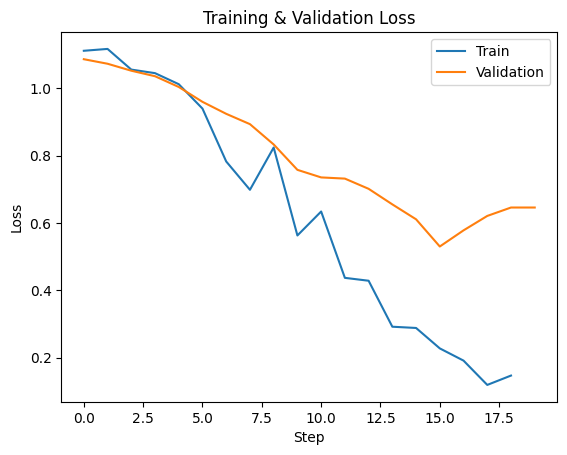

In [9]:
print("\nEvaluation Metrics:")
print(f"Validation Loss: {metrics['eval_loss']:.3f}")
print(f"Validation Accuracy: {metrics['eval_accuracy']:.3f}")
print(f"F1 Score: {metrics['eval_f1_macro']:.3f}")

# Extract metrics for plotting
train_loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
val_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
val_f1 = [x['eval_f1_macro'] for x in history if 'eval_f1_macro' in x]

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Final evaluation
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

# Confusion Matrix - raw text
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(val_labels, preds)
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, preds, target_names=label_encoder.classes_))

g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Confusion Matrix:
[[1 0 0]
 [0 1 0]
 [1 0 0]]

Classification Report:
                     precision    recall  f1-score   support

     Adverse Effect       0.50      1.00      0.67         1
Neutral Observation       1.00      1.00      1.00         1
   Positive Outcome       0.00      0.00      0.00         1

           accuracy                           0.67         3
          macro avg       0.50      0.67      0.56         3
       weighted avg       0.50      0.67      0.56         3



g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and be

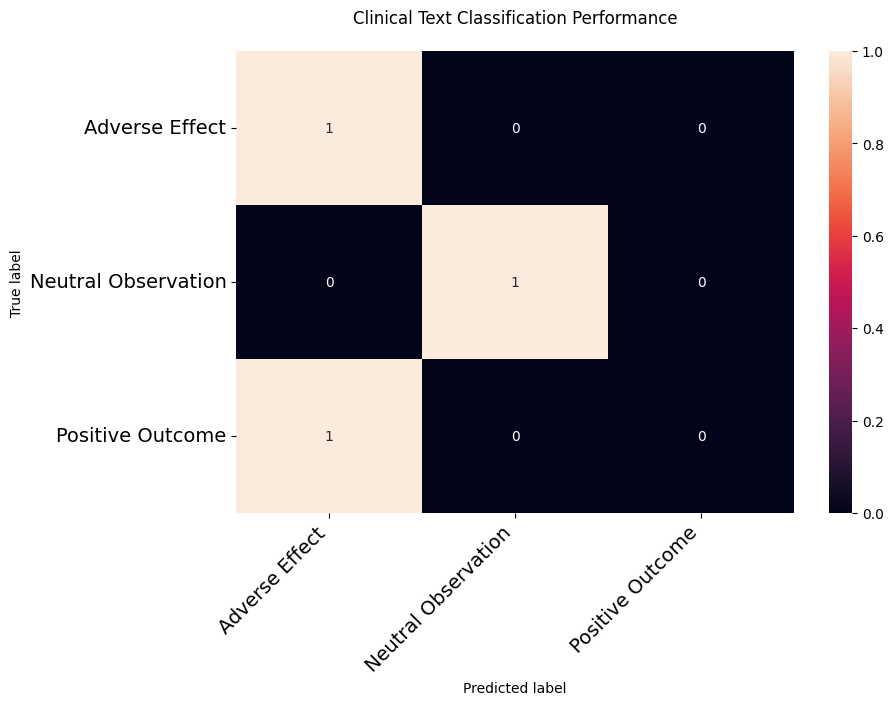

In [11]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Adverse Effect', 'Neutral Observation', 'Positive Outcome']
print_confusion_matrix(conf_matrix, class_names)
plt.title('Clinical Text Classification Performance', pad=20)
plt.show()

# Model trained on all data

Train the model on ALL the data

In [12]:
# After evaluation, train on ALL data
final_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(class_names)
)

# Tokenize ALL data (no validation split)
full_encodings = tokenizer(classification_df['text'].tolist(), truncation=True, padding=True)
full_dataset = ClassificationDataset(full_encodings, classification_df['label_encoded'].tolist())

# For final full-data training: Disable evaluation
final_training_args = replace(
    training_args,
    eval_strategy="no",  # No validation during full training
    load_best_model_at_end=False,  # No validation = no "best" model
    report_to="wandb",
    run_name="helix-classification_v4_final",

    # Specify to 12 since this was the epoch number that led to the best results
    num_train_epochs=12
)

# Train on entire dataset
trainer_final = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=full_dataset
)

trainer_final.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
g:\Libraries\OneDrive - McMaster University\McMaster Docs (MAC)\Work\FT Job\Aten Security\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,1.098400
10,1.091800
15,1.074200
20,1.000200
25,1.027900
30,0.965500
35,0.894600
40,0.753400
45,0.798600
50,0.670400


TrainOutput(global_step=180, training_loss=0.42797866761684417, metrics={'train_runtime': 57.5115, 'train_samples_per_second': 3.13, 'train_steps_per_second': 3.13, 'total_flos': 698571005400.0, 'train_loss': 0.42797866761684417, 'epoch': 12.0})

# Deliverable 4: Examples
- Show model predictions on at least 5 example sentences

In [13]:
# choose to use validated model
# final_model = model # comment if you'd like to use the model trained on all the data

In [16]:
# 12. Make predictions on sample text (DeepSeek generated)
def predict(text, model=final_model, return_probs=True):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    pred_class = torch.argmax(probs).item()

    if return_probs:
        return {
            'prediction': label_encoder.inverse_transform([pred_class])[0],
            'confidence': probs.max().item(),
            'probabilities': {cls: prob.item() for cls, prob in zip(class_names, probs[0])}
        }
    return label_encoder.inverse_transform([pred_class])[0]

# Test predictions
sample_texts = [
    # AI generated examples
    "Patient reported severe nausea after medication administration.", # generated
    "The treatment resulted in significant improvement of symptoms.", # generated
    "Blood pressure was measured at 120/80 mmHg.", # generated

    # Modified AI generated examples
    "Patient reported nausea after medication administration.", # removed word 'severe' to see if it can still guess ADVERSE
    "Patient avoided severe complications after medication administration.", # try 'AVOID SEVERE' together, misclassified
    "The treatment resulted in improvement of symptoms.", # removed word 'significant'to see if it can still guess POSITIVE,
    "No adverse events reported",
]

print("\n=== DETAILED PREDICTIONS ===")
for text in sample_texts:
    result = predict(text, model, return_probs=True)
    print(f"\nText: {text[:80]}...")
    print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.2f})")
    print("Class Probabilities:")
    for cls, prob in result['probabilities'].items():
        print(f"- {cls}: {prob:.3f}")


=== DETAILED PREDICTIONS ===

Text: Patient reported severe nausea after medication administration....
Prediction: Adverse Effect (confidence: 0.90)
Class Probabilities:
- Adverse Effect: 0.902
- Neutral Observation: 0.038
- Positive Outcome: 0.060

Text: The treatment resulted in significant improvement of symptoms....
Prediction: Positive Outcome (confidence: 0.82)
Class Probabilities:
- Adverse Effect: 0.119
- Neutral Observation: 0.058
- Positive Outcome: 0.823

Text: Blood pressure was measured at 120/80 mmHg....
Prediction: Neutral Observation (confidence: 0.70)
Class Probabilities:
- Adverse Effect: 0.136
- Neutral Observation: 0.698
- Positive Outcome: 0.166

Text: Patient reported nausea after medication administration....
Prediction: Adverse Effect (confidence: 0.90)
Class Probabilities:
- Adverse Effect: 0.900
- Neutral Observation: 0.039
- Positive Outcome: 0.060

Text: Patient avoided severe complications after medication administration....
Prediction: Adverse Effect (con